In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [2]:
dataset_path = '/home/ionan/dev/data/MAPS'
mus_folder_name = 'MUS'
output_folder = '/home/ionan/dev/data/processed_MUS'


In [54]:
def get_mus_files(dataset_path, file_extension):
    mus_files = []
    for instrument_folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, instrument_folder)
        if os.path.isdir(folder_path):
            mus_path = os.path.join(folder_path, mus_folder_name)
            if os.path.exists(mus_path):
                for file_name in os.listdir(mus_path):
                    if file_name.endswith(file_extension):
                        mus_files.append(os.path.join(mus_path, file_name))

    return mus_files


In [55]:
mus_wav_files = get_mus_files(dataset_path, '.wav')
mus_midi_files = get_mus_files(dataset_path, '.mid')
mus_txt_files = get_mus_files(dataset_path, '.txt')
mus_files = mus_wav_files + mus_midi_files + mus_txt_files
mus_files.sort()
print(f"Found {len(mus_files)} total MUS files.")

print(f"Found {len(mus_wav_files)} MUS wav files.")


Found 810 total MUS files.
Found 270 MUS wav files.


In [61]:
output_folder_audio = output_folder + '/audio'
output_folder_text = output_folder + '/text'

os.makedirs(output_folder_audio, exist_ok=True)
os.makedirs(output_folder_text, exist_ok=True)

mus_wav_files = get_mus_files(dataset_path, '.wav')
mus_txt_files = get_mus_files(dataset_path, '.txt')

# for wav_file in mus_wav_files:
#     shutil.copy(wav_file, output_folder_audio)

for txt_file in mus_txt_files:
    shutil.copy(txt_file, output_folder_text)



Copied 39 .wav files and 270 .txt files to /home/ionan/dev/data/processed_MUS


In [38]:
sample_file = mus_wav_files[1]
librosa.get_samplerate(sample_file)

44100

In [39]:
def process_audio(file_path, sr=16000):
    y, original_sr = librosa.load(file_path, sr=None)

    y_resampled = librosa.resample(y, orig_sr=original_sr, target_sr=sr)

    cqt = librosa.cqt(y_resampled, sr=sr)

    cqt_db = librosa.amplitude_to_db(np.abs(cqt))

    return cqt_db


In [40]:
cqt_db = process_audio(sample_file)
cqt_db

array([[-51.826534, -50.125153, -48.88386 , ..., -45.494404, -45.527996,
        -46.035126],
       [-55.356945, -54.450565, -53.596657, ..., -50.205307, -50.50839 ,
        -50.695023],
       [-62.238747, -64.30105 , -64.30105 , ..., -56.730865, -57.34804 ,
        -55.15131 ],
       ...,
       [-64.30105 , -64.30105 , -64.30105 , ..., -64.30105 , -64.30105 ,
        -64.30105 ],
       [-64.30105 , -64.30105 , -64.30105 , ..., -64.30105 , -64.30105 ,
        -64.30105 ],
       [-64.30105 , -64.30105 , -64.30105 , ..., -64.30105 , -64.30105 ,
        -64.30105 ]], dtype=float32)

In [41]:
def normalize_features(cqt_db, mean=None, std=None):
    if mean is None and std is None:
        # Calculate mean and standard deviation across the dataset
        mean = np.mean(cqt_db)
        std = np.std(cqt_db)

    normalized_cqt = (cqt_db - mean) / std
    return normalized_cqt, mean, std


In [42]:
cqt_normalized, mean, std = normalize_features(cqt_db)


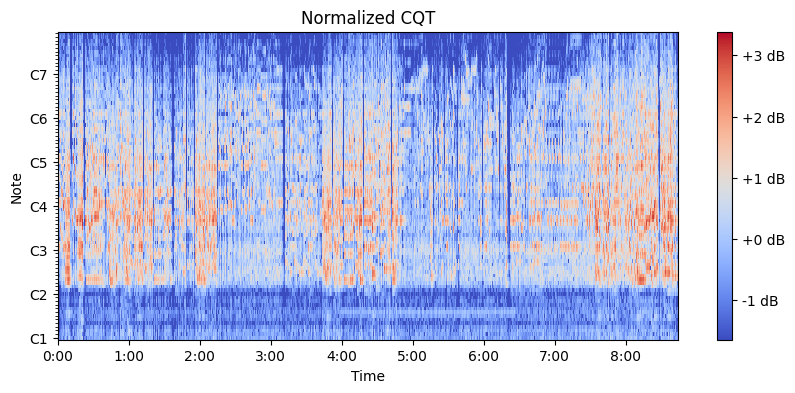

In [43]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(cqt_normalized, sr=16000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Normalized CQT')
plt.show()


In [45]:
def compute_global_mean_std(file_list, sr=16000):
    total_sum = 0
    total_squared_sum = 0
    total_frames = 0

    for file_path in file_list:
        cqt_db = process_audio(file_path, sr)

        # Accumulate mean and variance components
        total_sum += np.sum(cqt_db)
        total_squared_sum += np.sum(cqt_db ** 2)
        total_frames += cqt_db.size  # Count total number of data points

    # Calculate global mean and std
    global_mean = total_sum / total_frames
    global_variance = (total_squared_sum / total_frames) - (global_mean ** 2)
    global_std = np.sqrt(global_variance)

    return global_mean, global_std

# Compute the global mean and std for the dataset
# global_mean, global_std = compute_global_mean_std(mus_wav_files)

# # Save the global mean and std to use during training
# np.save('global_mean.npy', global_mean)
# np.save('global_std.npy', global_std)

# print(f"Global Mean: {global_mean}, Global Std: {global_std}")


Global Mean: -47.956548361624186, Global Std: 17.81806527665399


In [47]:
def normalize_with_global_stats(cqt_db, global_mean, global_std):
    return (cqt_db - global_mean) / global_std

global_mean = np.load('global_mean.npy')
global_std = np.load('global_std.npy')

cqt_db = process_audio(sample_file)
cqt_normalized = normalize_with_global_stats(cqt_db, global_mean, global_std)


In [49]:
def compute_global_min_max(file_list, sr=16000):
    min_X = []
    max_X = []

    for file_path in file_list:
        cqt_db = process_audio(file_path, sr)
        min_X.append(np.min(cqt_db))
        max_X.append(np.max(cqt_db))

    global_min = min(min_X)
    global_max = max(max_X)

    return global_min, global_max

global_min, global_max = compute_global_min_max(mus_wav_files)
np.save('global_min.npy', global_min)
np.save('global_max.npy', global_max)

print(f"Global Min: {global_min}, Global Max: {global_max}")

def normalize_with_min_max(cqt_db, global_min, global_max):
    return (cqt_db - global_min) / (global_max - global_min)


Global Min: -93.72282409667969, Global Max: 15.698948860168457


In [50]:
normalized_folder = '/home/ionan/dev/data/MAPS - Training 1'
os.makedirs(normalized_folder, exist_ok=True)


In [48]:
def save_normalized_cqt_global_stats(file_path, sr=16000, global_mean=None, global_std=None):
    cqt_db = process_audio(file_path, sr)

    cqt_normalized = normalize_with_global_stats(cqt_db, global_mean, global_std)

    file_name = os.path.splitext(os.path.basename(file_path))[0] + '_normalized.npy'
    save_path = os.path.join(normalized_folder, file_name)

    np.save(save_path, cqt_normalized)

    print(f"Saved normalized file: {save_path}")

global_mean = np.load('global_mean.npy')
global_std = np.load('global_std.npy')

for file_path in mus_wav_files:
    save_normalized_cqt_global_stats(file_path, global_mean=global_mean, global_std=global_std)


Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-muss_1_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-liz_rhap12_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-ty_mai_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-bk_xmas1_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-waldstein_1_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-ty_maerz_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-scn15_6_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-chpn-p4_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-chpn_op7_1_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/M

In [51]:

def save_normalized_cqt_min_max(file_path, global_min, global_max, sr=16000):
    cqt_db = process_audio(file_path, sr)

    cqt_normalized = normalize_with_min_max(cqt_db, global_min, global_max)


    file_name = os.path.splitext(os.path.basename(file_path))[0] + '_normalized.npy'
    save_path = os.path.join(normalized_folder, file_name)

    np.save(save_path, cqt_normalized)
    print(f"Saved normalized file: {save_path}")

global_min = np.load('global_min.npy')
global_max = np.load('global_max.npy')

for file_path in mus_wav_files:
    save_normalized_cqt_min_max(file_path, global_min, global_max)


Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-muss_1_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-liz_rhap12_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-ty_mai_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-bk_xmas1_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-waldstein_1_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-ty_maerz_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-scn15_6_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-chpn-p4_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/MAPS_MUS-chpn_op7_1_ENSTDkAm_normalized.npy
Saved normalized file: /home/ionan/dev/data/MAPS - Training 1/M

In [ ]:
hop_length_in = 512
n_bins_in = 252
bins_octaves_in = 36
win_len = 512 / 16000  # Assuming 16kHz sampling rate
number_notes = 88  # Piano has 88 keys
length_per_file = 4000000

In [ ]:
source_wav_folder = '/path/to/wav_files/'
source_txt_folder = '/path/to/txt_files/'
output_folder = '/path/to/output_folder/'


In [ ]:
global_min = np.load('global_min.npy')
global_max = np.load('global_max.npy')
